In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import roc_curve, confusion_matrix, auc, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Display of pandas dataframes 
from IPython.display import display


### add additional imports from sklearn that you may need - no other package is needed!
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('../data/thyroidDF.csv')

In [3]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047


<Axes: xlabel='TBG', ylabel='Count'>

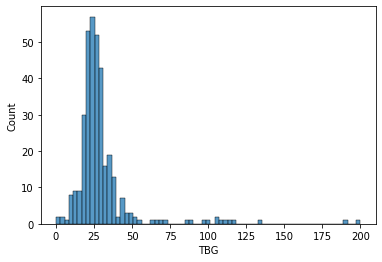

In [4]:
sns.histplot(df, x='TBG')

In [5]:
df_ohne_abn_age = df[(df['age'] <= 100)]

<Axes: xlabel='age', ylabel='TSH'>

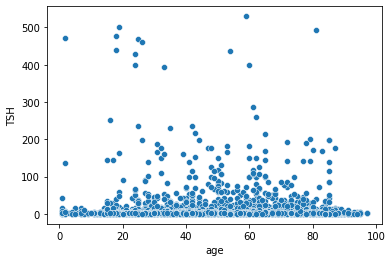

In [6]:
sns.scatterplot(df_ohne_abn_age, x='age', y = 'TSH')

In [7]:
#df = df.loc[df['TBG']<=45]

<Axes: xlabel='sick', ylabel='TBG'>

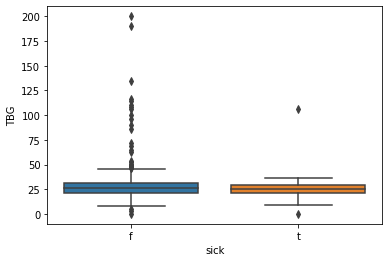

In [8]:
sns.boxplot(df, x='sick', y='TBG')

In [9]:
#Falsche Alterswerte!!
df['age'].nlargest(10)

8105    65526
6392    65512
5710    65511
2976      455
790        97
7355       97
7356       97
5758       95
8155       95
8968       95
Name: age, dtype: int64

In [10]:
#viele hohe TSH werte
df['TSH'].nlargest(10)

3075    530.0
8866    500.0
7219    494.0
5181    478.0
4496    472.0
4854    468.0
8181    460.0
3346    440.0
6932    436.0
425     430.0
Name: TSH, dtype: float64

In [11]:
#tiefer Mittelwert
df['TSH'].mean()

5.218402753781513

In [12]:
df['TSH'].median()

1.4

In [13]:
#outliers finden für TSH
Q1 = df['TSH'].quantile(0.25)
Q3 = df['TSH'].quantile(0.75)
IQR = Q3 - Q1
#lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR 
outliers_upper = df[(df['TSH'] > upper_bound)].shape[0]

print("Number of outliers above upper bound:", outliers_upper)

Number of outliers above upper bound: 884


<Axes: xlabel='TSH', ylabel='Count'>

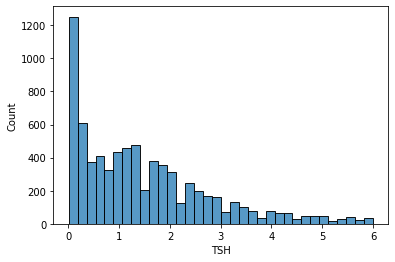

In [14]:
df_no_outliers = df[(df['TSH'] <= upper_bound)]
sns.histplot(df_no_outliers['TSH'], kde=False)

<Axes: ylabel='TSH'>

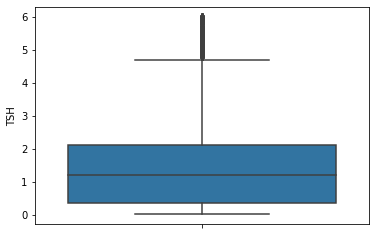

In [15]:
#Boxplot theoretisch ohne outliers nach IQR
sns.boxplot(df_no_outliers, y='TSH')

<Axes: xlabel='TSH', ylabel='Count'>

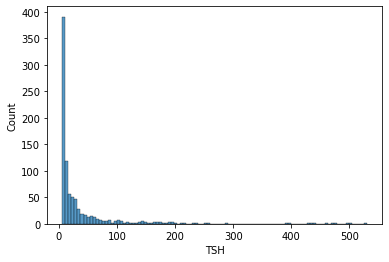

In [16]:
df_only_outliers = df[(df['TSH'] >= upper_bound)]
sns.histplot(df_only_outliers['TSH'], kde=False)

<Axes: xlabel='TSH', ylabel='Count'>

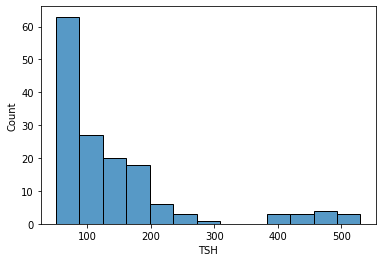

In [17]:
#normale TSH range: 0.4 - 4.0
#mild to moderate elevation: 4 - 10
#above 10 mlU/L severe elevation

#verteilung ab 50:
df_TSH_above_severe = df[(df['TSH'] > 50)]
sns.histplot(df_TSH_above_severe['TSH'], kde=False)

In [18]:
df['T3'].nlargest(10)

7224    18.000000
7693    13.299999
4853    10.599999
7367     9.500000
1529     8.900000
1733     8.900000
427      8.599999
4718     8.500000
1716     8.099999
9024     8.000000
Name: T3, dtype: float64

In [19]:
df['T3'].mean()

1.970628805724726

<Axes: xlabel='T3', ylabel='Count'>

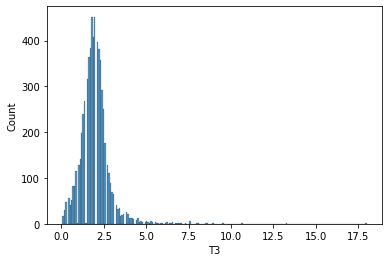

In [20]:
sns.histplot(df['T3'])

In [21]:
df['TT4'].nlargest(10)

6793    600.0
1658    450.0
2476    430.0
2514    430.0
7224    430.0
7693    410.0
6330    395.0
6512    386.0
3694    372.0
427     359.0
Name: TT4, dtype: float64

In [22]:
df['TT4'].mean()

108.70030469644902

<Axes: xlabel='TT4', ylabel='Count'>

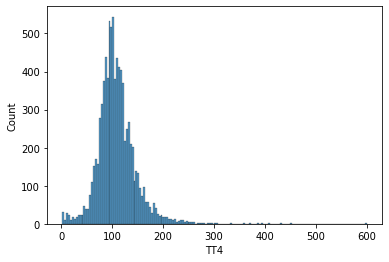

In [23]:
sns.histplot(df['TT4'])

In [24]:
#Zeilen bei denen TSH, T3 und TT4 werte alle in top 10%
# Calculate the 90th percentile for each of the TSH, T3, and TT4 columns
tsh_90th = df['TSH'].quantile(0.90)
t3_90th = df['T3'].quantile(0.90)
tt4_90th = df['TT4'].quantile(0.90)

# Create a boolean mask for rows where all three values are in the top 10%
mask = ((df['TSH'] >= tsh_90th) & (df['T3'] >= t3_90th) & (df['TT4'] >= tt4_90th))

# Create a new dataframe containing only the rows where the mask is True
df_top_10 = df.loc[mask]

# Print the new dataframe
print(df_top_10[['age','on_thyroxine', 'sick', 'TSH', 'T3', 'TT4']])

      age on_thyroxine sick        TSH   T3    TT4
1529   59            f    f  24.000000  8.9  218.0
1810   38            f    f   9.599999  4.8  168.0
2853   64            f    f   7.600000  4.2  164.0
3478   87            f    f  15.000000  4.5  239.0
3639   25            f    f  36.000000  4.5  162.0
4053   34            t    f   8.299999  3.1  172.0
4543   45            t    f   9.000000  2.8  237.0
5132   34            f    f  27.000000  4.4  273.0
5869   32            f    f   7.800000  5.5  166.0
8215   57            f    f  31.000000  4.1  230.0
8323   30            f    f  15.000000  5.6  278.0
8902   84            f    f  14.000000  6.7  280.0


In [25]:
df['TSH'].quantile(0.9)

6.5

In [26]:
#Df mit sick = True bzw. 't'
# Create a boolean mask for rows where the 'sick' column is True
mask = (df['sick'] == 't')

# Create a new dataframe containing only the rows where the mask is True
df_sick = df.loc[mask]

# Print the age, TSH, T3, TT4, and T4U columns of the new dataframe
print(df_sick[['age', 'TSH', 'T3', 'TT4', 'T4U']])

      age        TSH   T3    TT4   T4U
18     63  68.000000  NaN   48.0  1.02
45     51   1.500000  1.2   60.0  0.89
62     44   1.100000  1.5  105.0  0.90
71     61   9.799999  1.2  114.0  0.84
101    49   0.600000  0.8   57.0  0.70
...   ...        ...  ...    ...   ...
9025   61   2.300000  NaN   93.0  0.95
9066   79   1.700000  NaN   90.0  0.98
9069   80   0.080000  2.5   68.0  0.83
9086   79   2.000000  1.8  103.0  1.00
9134   74  53.000000  1.0   49.0  1.25

[344 rows x 5 columns]


In [27]:
df_sick['TSH'].nlargest(10)

18      68.0
9134    53.0
7128    32.0
5649    29.0
8480    23.0
8625    22.0
5316    13.0
2234    12.0
1782    11.0
3914    11.0
Name: TSH, dtype: float64

In [28]:
df['TSH'].isna().sum()

842

In [29]:
df.isnull().sum()

age                       0
sex                     307
on_thyroxine              0
query_on_thyroxine        0
on_antithyroid_meds       0
sick                      0
pregnant                  0
thyroid_surgery           0
I131_treatment            0
query_hypothyroid         0
query_hyperthyroid        0
lithium                   0
goitre                    0
tumor                     0
hypopituitary             0
psych                     0
TSH_measured              0
TSH                     842
T3_measured               0
T3                     2604
TT4_measured              0
TT4                     442
T4U_measured              0
T4U                     809
FTI_measured              0
FTI                     802
TBG_measured              0
TBG                    8823
referral_source           0
target                    0
patient_id                0
dtype: int64

In [30]:
'''#Random Forest funktioniert nicht... 'target' nicht binary
# Create a list of the feature columns
feature_cols = ['age', 'sex', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds', 'thyroid_surgery', 'query_hypothyroid', 'query_hyperthyroid', 'pregnant', 'sick', 'tumor', 'lithium', 'goitre', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured']

# Create a dataframe of the feature data
X = df[feature_cols]

# Create a series of the target variable
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier object with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred = rf.predict(X_test)

# Calculate the accuracy score of the model
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')'''


"#Random Forest funktioniert nicht... 'target' nicht binary\n# Create a list of the feature columns\nfeature_cols = ['age', 'sex', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds', 'thyroid_surgery', 'query_hypothyroid', 'query_hyperthyroid', 'pregnant', 'sick', 'tumor', 'lithium', 'goitre', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured']\n\n# Create a dataframe of the feature data\nX = df[feature_cols]\n\n# Create a series of the target variable\ny = df['target']\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Create a random forest classifier object with 100 trees\nrf = RandomForestClassifier(n_estimators=100, random_state=42)\n\n# Fit the model to the training data\nrf.fit(X_train, y_train)\n\n# Use the model to make predictions on the test data\ny_pred = rf.predict(X_test)\n\n# Calculate the accuracy score of 

In [31]:
# check for missing data in each column
missing_data = df.isnull()

# see which columns have any missing data
columns_with_missing_data = missing_data.any()

# print the column names that have missing data
print(columns_with_missing_data[columns_with_missing_data == True].index.tolist())

['sex', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']


In [32]:
# Create a SimpleImputer object with 'mean' strategy
imputer = SimpleImputer(strategy='mean')

# Impute missing values in the TSH column
df['TSH'] = imputer.fit_transform(df[['TSH']])

# Impute missing values in the T3 column
df['T3'] = imputer.fit_transform(df[['T3']])

# Impute missing values in the TT4 column
df['TT4'] = imputer.fit_transform(df[['TT4']])

# Impute missing values in the T4U column
df['T4U'] = imputer.fit_transform(df[['T4U']])

# Impute missing values in the FTI column
df['FTI'] = imputer.fit_transform(df[['FTI']])

# Impute missing values in the TBG column
df['TBG'] = imputer.fit_transform(df[['TBG']])

In [33]:
df.isnull().sum()

age                      0
sex                    307
on_thyroxine             0
query_on_thyroxine       0
on_antithyroid_meds      0
sick                     0
pregnant                 0
thyroid_surgery          0
I131_treatment           0
query_hypothyroid        0
query_hyperthyroid       0
lithium                  0
goitre                   0
tumor                    0
hypopituitary            0
psych                    0
TSH_measured             0
TSH                      0
T3_measured              0
T3                       0
TT4_measured             0
TT4                      0
T4U_measured             0
T4U                      0
FTI_measured             0
FTI                      0
TBG_measured             0
TBG                      0
referral_source          0
target                   0
patient_id               0
dtype: int64

In [34]:
# Calculate the ratio of males to females
male_count = df[df["sex"] == "M"].shape[0]
female_count = df[df["sex"] == "F"].shape[0]
ratio = male_count / female_count

# Fill in missing sex values with the ratio applied to the missing values
missing_sex_count = df["sex"].isnull().sum()
missing_male_count = int(round(missing_sex_count / (ratio + 1)))
missing_female_count = missing_sex_count - missing_male_count

df.loc[df["sex"].isnull(), "sex"] = ["M"] * missing_male_count + ["F"] * missing_female_count

In [35]:
df.isnull().sum()

age                    0
sex                    0
on_thyroxine           0
query_on_thyroxine     0
on_antithyroid_meds    0
sick                   0
pregnant               0
thyroid_surgery        0
I131_treatment         0
query_hypothyroid      0
query_hyperthyroid     0
lithium                0
goitre                 0
tumor                  0
hypopituitary          0
psych                  0
TSH_measured           0
TSH                    0
T3_measured            0
T3                     0
TT4_measured           0
TT4                    0
T4U_measured           0
T4U                    0
FTI_measured           0
FTI                    0
TBG_measured           0
TBG                    0
referral_source        0
target                 0
patient_id             0
dtype: int64

In [36]:
df['T4U']

0       0.976056
1       0.976056
2       0.976056
3       0.976056
4       0.976056
          ...   
9167    0.830000
9168    0.920000
9169    1.270000
9170    0.850000
9171    1.020000
Name: T4U, Length: 9172, dtype: float64

In [37]:
# One-hot encode 'sex' column
df = pd.get_dummies(df, columns=['sex'])

# Loop through all columns with binary values and one-hot encode them
for col in df.columns:
    if df[col].dtype == 'object' and set(df[col].unique()) == {'t', 'f'}:
        df[col] = df[col].apply(lambda x: 1 if x == 't' else 0)
        df = pd.get_dummies(df, columns=[col])

# Print the updated dataframe
print(df.head())

   age       TSH        T3         TT4       T4U         FTI        TBG  \
0   29  0.300000  1.970629  108.700305  0.976056  113.640746  29.870057   
1   29  1.600000  1.900000  128.000000  0.976056  113.640746  29.870057   
2   41  5.218403  1.970629  108.700305  0.976056  113.640746  11.000000   
3   36  5.218403  1.970629  108.700305  0.976056  113.640746  26.000000   
4   32  5.218403  1.970629  108.700305  0.976056  113.640746  36.000000   

  referral_source target  patient_id  ...  T3_measured_0  T3_measured_1  \
0           other      -   840801013  ...              1              0   
1           other      -   840801014  ...              0              1   
2           other      -   840801042  ...              1              0   
3           other      -   840803046  ...              1              0   
4           other      S   840803047  ...              1              0   

   TT4_measured_0  TT4_measured_1  T4U_measured_0  T4U_measured_1  \
0               1            

In [38]:
print(df['sex_M'])

0       0
1       0
2       0
3       0
4       0
       ..
9167    1
9168    1
9169    1
9170    0
9171    1
Name: sex_M, Length: 9172, dtype: uint8


In [39]:
'''# Create a label encoder object
le = LabelEncoder()

# Encode the target column
df['target'] = le.fit_transform(df['target'])'''
print(df['target'])

0       -
1       -
2       -
3       -
4       S
       ..
9167    -
9168    -
9169    I
9170    -
9171    -
Name: target, Length: 9172, dtype: object


In [40]:
#Decision Tree
# Split the dataset into training and testing sets
X = df[['age', 'sex_F', 'sex_M', 'on_thyroxine_1', 'on_thyroxine_0', 'query_hyperthyroid_1',
                  'query_hyperthyroid_0', 'query_hypothyroid_1', 'query_hypothyroid_0', 'pregnant_1',
                  'pregnant_0', 'thyroid_surgery_1', 'thyroid_surgery_0', 'I131_treatment_1',
                  'I131_treatment_0', 'query_on_thyroxine_1', 'query_on_thyroxine_0', 'on_antithyroid_meds_1',
                  'on_antithyroid_meds_0', 'sick_1', 'sick_0', 'tumor_1', 'tumor_0', 'lithium_1', 'lithium_0',
                  'goitre_1', 'goitre_0', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']] # Features
y = df['target'] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train the decision tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Make predictions on the testing set and evaluate the model performance
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

print('\nClassification Report:\n', classification_report(y_test, y_pred))



Accuracy: 0.9313351498637602

Classification Report:
               precision    recall  f1-score   support

           -       0.96      0.96      0.96      1328
           A       0.68      0.81      0.74        21
          AK       0.67      0.60      0.63        10
           B       0.17      0.25      0.20         4
           C       0.00      0.00      0.00         0
           F       0.97      0.93      0.95        40
          FK       1.00      1.00      1.00         1
           G       1.00      0.99      0.99        69
          GI       0.00      0.00      0.00         1
          GK       0.86      1.00      0.92         6
         H|K       0.00      0.00      0.00         0
           I       0.78      0.84      0.81        82
           J       0.91      0.83      0.87        12
           K       0.89      0.81      0.85       106
          KJ       1.00      1.00      1.00         2
           L       0.72      0.64      0.68        28
           M       1.00    

/Users/rikfranssen/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rikfranssen/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rikfranssen/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rikfrans

In [41]:
df.isna().sum()

age                      0
TSH                      0
T3                       0
TT4                      0
T4U                      0
FTI                      0
TBG                      0
referral_source          0
target                   0
patient_id               0
sex_F                    0
sex_M                    0
on_thyroxine_0           0
on_thyroxine_1           0
query_on_thyroxine_0     0
query_on_thyroxine_1     0
on_antithyroid_meds_0    0
on_antithyroid_meds_1    0
sick_0                   0
sick_1                   0
pregnant_0               0
pregnant_1               0
thyroid_surgery_0        0
thyroid_surgery_1        0
I131_treatment_0         0
I131_treatment_1         0
query_hypothyroid_0      0
query_hypothyroid_1      0
query_hyperthyroid_0     0
query_hyperthyroid_1     0
lithium_0                0
lithium_1                0
goitre_0                 0
goitre_1                 0
tumor_0                  0
tumor_1                  0
hypopituitary_0          0
h

In [42]:
#Random Forest
# Create a list of the feature columns
feature_cols = ['age', 'sex_F', 'sex_M', 'on_thyroxine_1', 'on_thyroxine_0', 'query_hyperthyroid_1',
                  'query_hyperthyroid_0', 'query_hypothyroid_1', 'query_hypothyroid_0', 'pregnant_1',
                  'pregnant_0', 'thyroid_surgery_1', 'thyroid_surgery_0', 'I131_treatment_1',
                  'I131_treatment_0', 'query_on_thyroxine_1', 'query_on_thyroxine_0', 'on_antithyroid_meds_1',
                  'on_antithyroid_meds_0', 'sick_1', 'sick_0', 'tumor_1', 'tumor_0', 'lithium_1', 'lithium_0',
                  'goitre_1', 'goitre_0', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']

# Create a dataframe of the feature data
X = df[feature_cols]

# Create a series of the target variable
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier object with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred = rf.predict(X_test)

# Calculate the accuracy score of the model
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.6f}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))


Accuracy: 0.924251

Classification Report:
               precision    recall  f1-score   support

           -       0.95      0.97      0.96      1328
           A       0.60      0.71      0.65        21
          AK       0.62      0.50      0.56        10
           B       0.00      0.00      0.00         4
           F       0.95      0.95      0.95        40
          FK       0.00      0.00      0.00         1
           G       0.97      1.00      0.99        69
          GI       0.00      0.00      0.00         1
          GK       0.86      1.00      0.92         6
           I       0.84      0.71      0.77        82
           J       1.00      0.25      0.40        12
           K       0.85      0.93      0.89       106
          KJ       1.00      0.50      0.67         2
           L       0.61      0.50      0.55        28
           M       1.00      1.00      1.00        25
          MK       1.00      1.00      1.00         6
           N       0.74      0.85    

/Users/rikfranssen/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rikfranssen/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rikfranssen/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


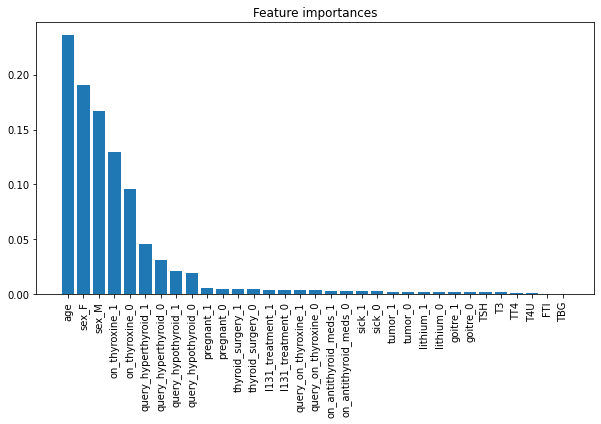

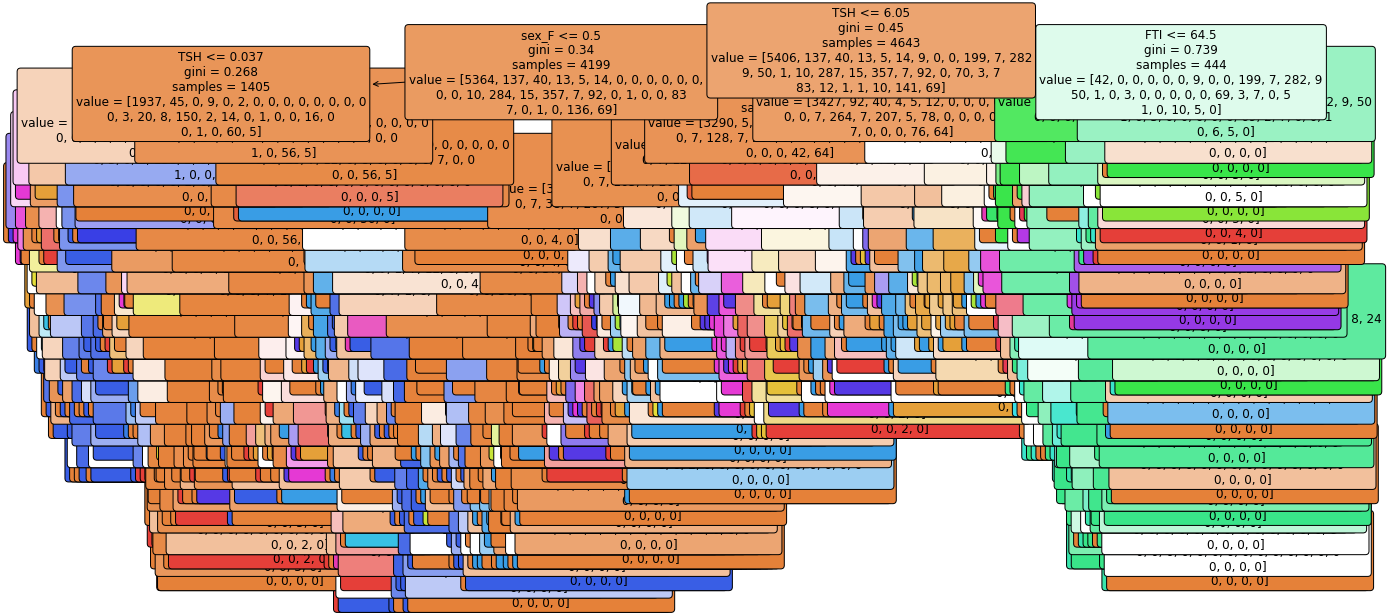

In [43]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), feature_cols, rotation=90)
plt.show()

# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(rf.estimators_[0], feature_names=feature_cols, filled=True, rounded=True, fontsize=12)
plt.savefig('plot_tree.png')

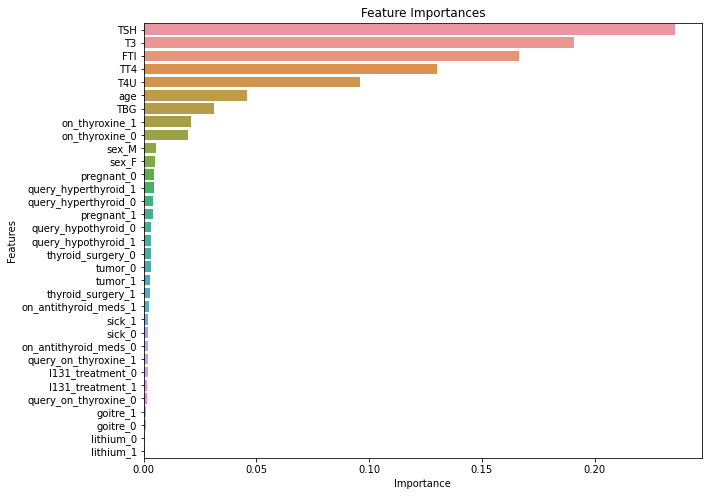

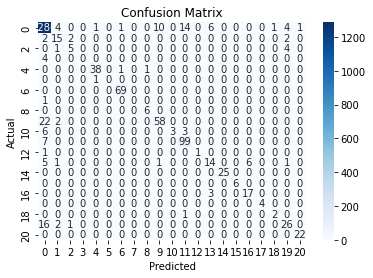

"# Precision-Recall Curve Plot\nfrom sklearn.metrics import precision_recall_curve\n\nprecision, recall, thresholds = precision_recall_curve(y_test, y_pred)\nplt.plot(recall, precision)\nplt.xlabel('Recall')\nplt.ylabel('Precision')\nplt.title('Precision-Recall Curve')\nplt.show()"

In [44]:
# Feature Importance Plot
feature_importances = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y=feature_importances.index, data=feature_importances)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Confusion Matrix Plot
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

'''# ROC Curve Plot
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()'''

'''# Precision-Recall Curve Plot
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()'''

In [45]:
df = df[df['age']<= 110]
df

,age,TSH,T3,TT4,T4U,FTI,TBG,referral_source,target,patient_id,...,T3_measured_0,T3_measured_1,TT4_measured_0,TT4_measured_1,T4U_measured_0,T4U_measured_1,FTI_measured_0,FTI_measured_1,TBG_measured_0,TBG_measured_1
0,29,0.300000,1.970629,108.700305,0.976056,113.640746,29.870057,other,-,840801013,...,1,0,1,0,1,0,1,0,1,0
1,29,1.600000,1.900000,128.000000,0.976056,113.640746,29.870057,other,-,840801014,...,0,1,0,1,1,0,1,0,1,0
2,41,5.218403,1.970629,108.700305,0.976056,113.640746,11.000000,other,-,840801042,...,1,0,1,0,1,0,1,0,0,1
3,36,5.218403,1.970629,108.700305,0.976056,113.640746,26.000000,other,-,840803046,...,1,0,1,0,1,0,1,0,0,1
4,32,5.218403,1.970629,108.700305,0.976056,113.640746,36.000000,other,S,840803047,...,1,0,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,56,5.218403,1.970629,64.000000,0.830000,77.000000,29.870057,SVI,-,870119022,...,1,0,0,1,0,1,0,1,1,0
9168,22,5.218403,1.970629,91.000000,0.920000,99.000000,29.870057,SVI,-,870119023,...,1,0,0,1,0,1,0,1,1,0
9169,69,5.218403,1.970629,113.000000,1.270000,89.000000,29.870057,SVI,I,870119025,...,1,0,0,1,0,1,0,1,1,0
9170,47,5.218403,1.970629,75.000000,0.850000,88.000000,29.870057,other,-,870119027,...,1,0,0,1,0,1,0,1,1,0


In [47]:
df['age'].nlargest(10)

790     97
7355    97
7356    97
5758    95
8155    95
8968    95
3938    94
5238    94
6772    94
9054    94
Name: age, dtype: int64